In [1]:
import dask
import dask.distributed
import dask_jobqueue
import pathlib
import xarray as xr

from crims2s.distribution import fit_normal_xarray
from crims2s.util import fix_dataset_dims, add_biweekly_dim

In [2]:
TRAINING_INPUT = '***BASEDIR***training-input'

In [3]:
train_input_path = pathlib.Path(TRAINING_INPUT)

In [4]:
files_list = []
for f in list(train_input_path.iterdir()):
    if 'ncep' in f.name and ('-t2m-' in f.name or '-tp-' in f.name):
        files_list.append(f)
files_list = sorted(files_list)

In [5]:
len(files_list)

102

In [10]:
sample = xr.open_dataset(files_list[0])

In [11]:
sample.forecast_time

<xarray.DataArray 'forecast_time' (forecast_time: 12)>
array(['1999-01-07T00:00:00.000000000', '2000-01-07T00:00:00.000000000',
       '2001-01-07T00:00:00.000000000', '2002-01-07T00:00:00.000000000',
       '2003-01-07T00:00:00.000000000', '2004-01-07T00:00:00.000000000',
       '2005-01-07T00:00:00.000000000', '2006-01-07T00:00:00.000000000',
       '2007-01-07T00:00:00.000000000', '2008-01-07T00:00:00.000000000',
       '2009-01-07T00:00:00.000000000', '2010-01-07T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 1999-01-07 ... 2010-01-07
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

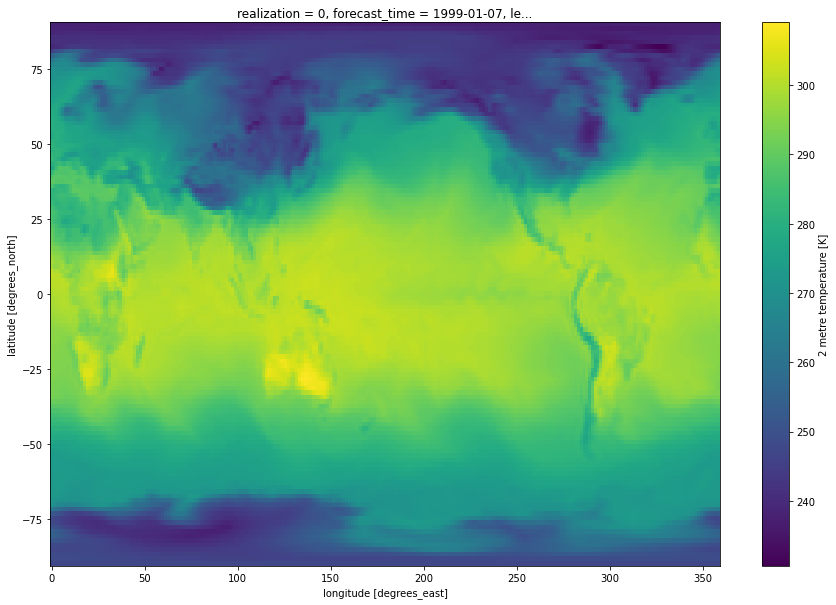

In [14]:
sample.isel(lead_time=0, realization=0, forecast_time=0).t2m.plot(size=10)

In [22]:
sample = add_biweekly_dim(xr.open_dataset(files_list[0]), weeks_12=False)

In [24]:
sample.isnull().sum(dim=['realization', 'forecast_time', 'latitude', 'longitude'])

<xarray.Dataset>
Dimensions:            (biweekly_forecast: 2, lead_time: 14)
Coordinates:
  * lead_time          (lead_time) timedelta64[ns] 0 days 1 days ... 13 days
  * biweekly_forecast  (biweekly_forecast) timedelta64[ns] 14 days 28 days
Data variables:
    t2m                (biweekly_forecast, lead_time) int64 0 0 0 0 ... 0 0 0 0

In [ ]:
sample.lead_time

In [25]:
parameters = fit_normal_xarray(sample.t2m, dim=['lead_time', 'realization'])

In [26]:
parameters

<xarray.Dataset>
Dimensions:            (forecast_time: 12, latitude: 121, longitude: 240, biweekly_forecast: 2)
Coordinates:
  * forecast_time      (forecast_time) datetime64[ns] 1999-01-07 ... 2010-01-07
  * latitude           (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude          (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * biweekly_forecast  (biweekly_forecast) timedelta64[ns] 14 days 28 days
Data variables:
    t2m_mu             (biweekly_forecast, forecast_time, latitude, longitude) float32 ...
    t2m_sigma          (biweekly_forecast, forecast_time, latitude, longitude) float32 ...

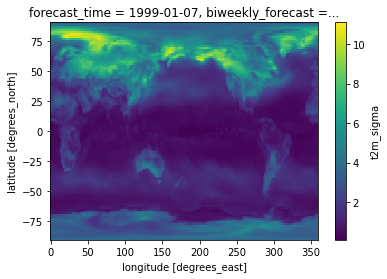

In [27]:
parameters.isel(forecast_time=0, biweekly_forecast=0).t2m_sigma.plot()

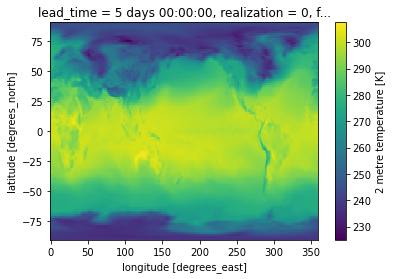

In [29]:
sample.isel(biweekly_forecast=1, lead_time=5, realization=0, forecast_time=0).t2m.plot()

In [32]:
cluster = dask_jobqueue.SLURMCluster(
    env_extra=['source ***HOME***.bash_profile','conda activate s2s'],
    name='s2s',
)

In [33]:
cluster.scale(jobs=2)

In [34]:
client = dask.distributed.Client(cluster)

In [35]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.20.40.201:8787/status,
Dashboard: http://10.20.40.201:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.20.40.201:46535,Workers: 0
Dashboard: http://10.20.40.201:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [36]:
d = xr.open_mfdataset(files_list, preprocess=fix_dataset_dims)

In [37]:
d = d.persist()

In [52]:
d.forecast_time

<xarray.DataArray 'forecast_time' (forecast_monthday: 51, forecast_year: 12)>
array([['1999-01-07T00:00:00.000000000', '2000-01-07T00:00:00.000000000',
        '2001-01-07T00:00:00.000000000', '2002-01-07T00:00:00.000000000',
        '2003-01-07T00:00:00.000000000', '2004-01-07T00:00:00.000000000',
        '2005-01-07T00:00:00.000000000', '2006-01-07T00:00:00.000000000',
        '2007-01-07T00:00:00.000000000', '2008-01-07T00:00:00.000000000',
        '2009-01-07T00:00:00.000000000', '2010-01-07T00:00:00.000000000'],
       ['1999-01-14T00:00:00.000000000', '2000-01-14T00:00:00.000000000',
        '2001-01-14T00:00:00.000000000', '2002-01-14T00:00:00.000000000',
        '2003-01-14T00:00:00.000000000', '2004-01-14T00:00:00.000000000',
        '2005-01-14T00:00:00.000000000', '2006-01-14T00:00:00.000000000',
        '2007-01-14T00:00:00.000000000', '2008-01-14T00:00:00.000000000',
        '2009-01-14T00:00:00.000000000', '2010-01-14T00:00:00.000000000'],
       ['1999-01-21T00:00:00.000000000', '2000-01-21T00:00:00.000000000',
        '2001-01-21T00:00:00.000000000', '2002-01-21T00:00:00.000000000',
        '2003-01-21T00:00:00.000000000', '2004-01-21T00:00:00.000000000',
        '2005-01-21T00:00:00.000000000', '2006-01-21T00:00:00.000000000',
        '2007-01-21T00:00:00.000000000', '2008-01-21T00:00:00.000000000',
        '2009-01-21T00:00:00.000000000', '2010-01-21T00:00:00.000000000'],
       ['1999-01-28T00:00:00.000000000', '2000-01-28T00:00:00.000000000',
        '2001-01-28T00:00:00.000000000', '2002-01-28T00:00:00.000000000',
...
        '2009-12-02T00:00:00.000000000', '2010-12-02T00:00:00.000000000'],
       ['1999-12-09T00:00:00.000000000', '2000-12-09T00:00:00.000000000',
        '2001-12-09T00:00:00.000000000', '2002-12-09T00:00:00.000000000',
        '2003-12-09T00:00:00.000000000', '2004-12-09T00:00:00.000000000',
        '2005-12-09T00:00:00.000000000', '2006-12-09T00:00:00.000000000',
        '2007-12-09T00:00:00.000000000', '2008-12-09T00:00:00.000000000',
        '2009-12-09T00:00:00.000000000', '2010-12-09T00:00:00.000000000'],
       ['1999-12-16T00:00:00.000000000', '2000-12-16T00:00:00.000000000',
        '2001-12-16T00:00:00.000000000', '2002-12-16T00:00:00.000000000',
        '2003-12-16T00:00:00.000000000', '2004-12-16T00:00:00.000000000',
        '2005-12-16T00:00:00.000000000', '2006-12-16T00:00:00.000000000',
        '2007-12-16T00:00:00.000000000', '2008-12-16T00:00:00.000000000',
        '2009-12-16T00:00:00.000000000', '2010-12-16T00:00:00.000000000'],
       ['1999-12-23T00:00:00.000000000', '2000-12-23T00:00:00.000000000',
        '2001-12-23T00:00:00.000000000', '2002-12-23T00:00:00.000000000',
        '2003-12-23T00:00:00.000000000', '2004-12-23T00:00:00.000000000',
        '2005-12-23T00:00:00.000000000', '2006-12-23T00:00:00.000000000',
        '2007-12-23T00:00:00.000000000', '2008-12-23T00:00:00.000000000',
        '2009-12-23T00:00:00.000000000', '2010-12-23T00:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
    forecast_time      (forecast_monthday, forecast_year) datetime64[ns] 1999...
  * forecast_monthday  (forecast_monthday) <U4 '0107' '0114' ... '1216' '1223'
  * forecast_year      (forecast_year) int64 1999 2000 2001 ... 2008 2009 2010
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [72]:
len(d.forecast_monthday)

51

In [66]:
for md in d.forecast_monthday:
    md= str(md.data)
    month = int(md[:2])
    day = int(md[2:])
    print(f'({month}, {day}),')

(1, 7),
(1, 14),
(1, 21),
(1, 28),
(2, 4),
(2, 11),
(2, 18),
(2, 25),
(3, 4),
(3, 11),
(3, 18),
(3, 25),
(4, 1),
(4, 8),
(4, 15),
(4, 22),
(4, 29),
(5, 6),
(5, 13),
(5, 20),
(5, 27),
(6, 3),
(6, 10),
(6, 17),
(6, 24),
(7, 1),
(7, 8),
(7, 15),
(7, 22),
(7, 29),
(8, 5),
(8, 12),
(8, 19),
(8, 26),
(9, 2),
(9, 9),
(9, 16),
(9, 23),
(9, 30),
(10, 7),
(10, 14),
(10, 21),
(10, 28),
(11, 4),
(11, 11),
(11, 18),
(11, 25),
(12, 2),
(12, 9),
(12, 16),
(12, 23),


In [39]:
nan_counts = d.tp.isnull().mean(dim=['forecast_year', 'forecast_monthday', 'lead_time', 'latitude', 'longitude']).compute()

In [40]:
nan_counts

<xarray.DataArray 'tp' (realization: 4)>
array([0.00098255, 0.00068877, 0.00053662, 0.0004485 ])
Coordinates:
  * realization  (realization) int64 0 1 2 3

In [ ]:
d.isnull().mean().compute()

In [51]:
d.interpolate_na(dim='realization').isnull().mean().compute()

KeyboardInterrupt: 

In [41]:
n_null = d.tp.isnull().sum(dim=['realization']).persist()

In [42]:
(n_null >= 1).mean().compute()

<xarray.DataArray 'tp' ()>
array(0.00195877)

In [43]:
(n_null >= 2).mean().compute()

<xarray.DataArray 'tp' ()>
array(0.00051519)

In [44]:
(n_null >= 3).mean().compute()

<xarray.DataArray 'tp' ()>
array(0.00014444)

In [45]:
(n_null == 4).mean().compute()

<xarray.DataArray 'tp' ()>
array(3.80401712e-05)

In [46]:
nan_counts.compute()

<xarray.DataArray 'tp' (realization: 4)>
array([0.00098255, 0.00068877, 0.00053662, 0.0004485 ])
Coordinates:
  * realization  (realization) int64 0 1 2 3